# Exploratory Data Analysis

This notebook does exploratory data analysis and formats the data, like removing low-quality examples and converting columns to numeric format.

In [1]:
import sys
sys.path.append("../")

import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Reading in the dataset
df = pd.read_csv('../data/newsqa-data-v1.csv')
df.head()

,story_id,question,answer_char_ranges,is_answer_absent,is_question_bad,validated_answers
0,./cnn/stories/42d01e187213e86f5fe617fe32e716ff...,What was the amount of children murdered?,294:297|None|None,0.0,0.0,"{""none"": 1, ""294:297"": 2}"
1,./cnn/stories/c48228a52f26aca65c31fad273e66164...,Where was one employee killed?,34:60|1610:1618|34:60,0.0,0.0,NaN
2,./cnn/stories/c65ed85800e4535f4bbbfa2c34d7d963...,who did say South Africa did not issue a visa ...,103:127|114:127|839:853,0.0,0.0,"{""839:853"": 1, ""103:127"": 2}"
3,./cnn/stories/0cf66b646e9b32076513c050edf32a79...,How many years old was the businessman?,538:550|538:550,0.0,0.0,NaN
4,./cnn/stories/13012604e3203c18df09289dfedd14cd...,What frightened the families?,690:742|688:791|630:646,0.0,0.0,"{""688:791"": 2, ""690:742"": 1}"


In [3]:
# Size of the dataset
len(df)

119633

In [4]:
# Convert to numeric and remove non-numeric rows
df = df[pd.to_numeric(df['is_question_bad'], errors = 'coerce').notnull()]
df['is_question_bad'] = df['is_question_bad'].astype(float)

# Number of bad questions
len(df[df['is_question_bad'] > 0])

20051

In [5]:
# Remove all bad questions/questions that don't make any sense
df = df[df['is_question_bad'] == 0]
df = df.reset_index(drop = True)

In [6]:
# Final data size
len(df)

87810

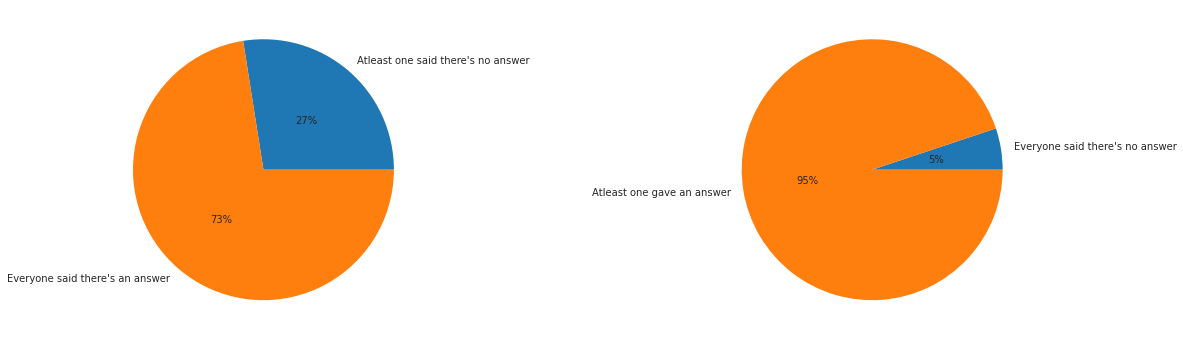

In [7]:
# Answer statistics
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

atleast_one_no_ans = len(df[df['is_answer_absent'] != 0])
sizes1 = [atleast_one_no_ans, len(df) - atleast_one_no_ans]
labels1 = ['Atleast one said there\'s no answer', 'Everyone said there\'s an answer']
ax[0].pie(sizes1, labels = labels1, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

all_no_ans = len(df[df['is_answer_absent'] == 1])
sizes2 = [all_no_ans, len(df) - all_no_ans]
labels2 = ['Everyone said there\'s no answer', 'Atleast one gave an answer']
ax[1].pie(sizes2, labels = labels2, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

plt.show()

In 22% of the cases where some said there is no answer and some crowdworkers provided an answer, it might be possible that some crowdworkers did not find an answer. In those cases, we can ignore the 'None' answer.

In [8]:
# Precentage of questions that have validated answers
100*df['validated_answers'].isnull().sum()/len(df)

56.02209315567703

In [9]:
# Story, question, answer example
# random.seed(0)
idx = random.randint(0, len(df))
with open(df['story_id'][idx]) as f:
    story = f.read()
    
question = df['question'][idx]
answers = re.split(',|\|', df['answer_char_ranges'][idx])

print("Story ({} words):".format(len(story)))
print(story)
print("\nQuestion ({} words): {}".format(len(question), question))

for ans_range in answers:
    if ans_range == 'None':
        print("Answer: None")
    else:
        indices = ans_range.split(':')
        print("Answer: ", story[int(indices[0]):int(indices[1])])

Story (2034 words):
(CNN)  -- The mayor of a small town in the state of Chihuahua in northern Mexico was found shot dead Tuesday, apparently among the latest victims in the fight against organized crime in the region.

Hector Ariel Meixueiro Munoz, 53, was mayor of Namiquipa, a small town in the state of Chihuahua.

The body of Hector Ariel Meixueiro Munoz, 53, mayor of Namiquipa, was found inside his SUV on the side of a road on the outskirts of the rural town of 20,000, said Eduardo Esparza, spokesman for the attorney general in the state of Chihuahua.

"He was on his way to work in the morning," said Esparza. "We are still trying to confirm if there was a police escort with him at the time."

The incident has put other officials in the region on alert. Ciudad Juarez Mayor Jose Reyes Ferriz told CNN during a phone interview that death threats are common in his town on the other side of the Rio Grande from El Paso, Texas.

"It's very sad," he said. "This mayor was fighting crime, he h

In [10]:
# Word counts in questions
cv = CountVectorizer(stop_words = ['the', 'is', 'was', 'of', 'to', 'in'])
dtm = cv.fit_transform(df['question']).toarray()

word_counts = dtm.sum(axis = 0)

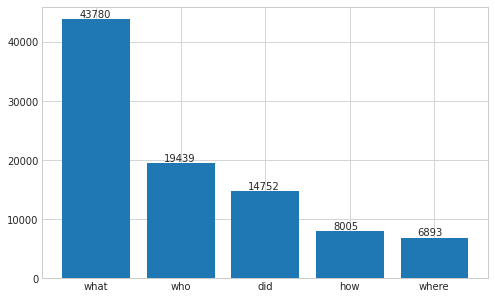

In [11]:
# Plotting top 5 words
fig, ax = plt.subplots(figsize = (8, 5))

sorted_idx = np.argsort(word_counts)[::-1]
vocab = np.array(cv.get_feature_names())

top_words_idx = sorted_idx[:5]
plt.bar(x = vocab[top_words_idx], height = word_counts[top_words_idx])

for i in range(len(top_words_idx)):
    plt.text(x = i - 0.2, y = word_counts[top_words_idx[i]] + 300, s = word_counts[top_words_idx[i]])

plt.show()

From this chart, we can see the types of questions in this dataset. Majority are 'What' questions followed by 'Who'.

In [14]:
# Removing the path and keeping just the file name in story_id
df['story_id'] = df['story_id'].apply(lambda x: x.split('/')[-1].split('.')[0])

In [15]:
# Saving the formatted data
df.to_csv('../data/newsqa-data-formatted.csv', index = False)